## Recap: Sensitivity analysis

Given a problem of the form
$$
    \large A(\lambda)u_h = b(\lambda), 
$$
the solution $u_h$ depends upon the parameter (vector) $\lambda$, so we write $u_h(\lambda)$.
Subsequently, $Q(u_h)$ also depends implicitly upon the parameter $\lambda$, and we write $Q(\lambda)$ to make this dependence explicit.
Since parameters are often subject to uncertainty, we are commonly interested in the sensitivity of the QoI with respect to perturbations in these parameters. 

Let $\lambda_i$ denote the $i$th component of the vector $\lambda$ for $1\leq i\leq m$.
Then, differentiating $A(\lambda)u_h = b(\lambda)$ with respect to $\lambda_i$ and following a similar set of steps as used to derive the computable error estimate, we arrive at
$$
 \large	\partial_{\lambda_i} Q(\lambda) = \left< \partial_{\lambda_i} {b}(\lambda) - \left[\partial_{\lambda_i}A(\lambda)\right] {u}(\lambda), {\phi}(\lambda) \right>.
$$
Here, $\phi(\lambda)$ depends upon $\lambda$ since $A^\top$ now also depends upon $\lambda$. 

We can also interpret this as $<\partial_{\lambda_i} R(u), \phi>$, the derivative of the **residual** with respect to the parameter $\lambda_i$. 

However, we only require the partial derivatives of the data and operator $A$ with respect to the parameters in order to determine the partial derivatives of $Q$. 
In other words, we solve ***two problems: the forward and adjoint problem*** and are able to determine the gradient of $Q$ even if $\lambda$ has dimension in the millions. 

What is the alternative?  You solve a linear algebra problem $\partial u/\partial \lambda_i$, one each parameter, of the form
$$
A \frac{\partial u}{\partial \lambda_i} = \frac{\partial R}{\lambda_i} (u).
$$
Even with a matrix factorization of $A$ this is still unappealing for a large number of parameters and a modest number of QoI.  




In [94]:
import numpy as np 
import scipy.sparse as sparse
import scipy.sparse.linalg as splinalg
import scipy.linalg as linalg
import matplotlib.pyplot as plt

#The next line enables the display of graphical output within Jupyter Notebooks and is NOT needed outside of Notebooks"
%matplotlib inline

## A More Interesting Forward UQ Problem

Consider the two-point boundary value problem
$$
    \large -(\alpha(x)u_x)_x = e^{\beta x}, \ x\in(0,1), \ u(0)=u(1)=0.
$$
Here, $\alpha(x)$ is some parameter, and $\beta(x)$ is a continuous diffusion coefficient. 



We use a three-point centered finite difference scheme on a uniform mesh of $(0,1)$ with grid spacing $h$ (defaults to 0.05) to discretize this problem into a matrix-vector problem of the form
$$
    \large A(\alpha)u_h = b(\beta), 
$$
where $u_h$ is a vector of nodal values that approximate the solution $u$ at the grid points of the mesh.

***As before, We are interested in $u_h$ not $u$ here. We simply use the differential equation to motivate the matrix-vector problem.***

In [95]:
#KL eigenfunctions and eigenvalues for Wiener Process

def efunc(x,k):
    return np.sqrt(2)*np.sin(np.pi*(k-.5)*x)
def eval(k):
    return 1.0/((k-.5)**2*np.pi**2)

# diffusion coefficient
def alpha_func(x,coeff,k=5):
    # 5 terms in K-L expansion
    alpha=np.zeros(x.shape)
    for i in range(1,k+1):
        alpha+=coeff[i-1]*np.sqrt(eval(i))*efunc(x,i)
    return 1+alpha



[ 1.          1.04567105  1.09099971  1.13564834  1.17928862  1.22160612
  1.26230452  1.30110955  1.33777263  1.37207407  1.4038257   1.43287315
  1.45909748  1.48241624  1.50278402  1.52019236  1.53466905  1.54627701
  1.55511246  1.56130274  1.5650036   1.5663961   1.56568322  1.56308612
  1.55884025  1.5531913   1.54639109  1.53869347  1.53035027  1.52160747
  1.51270152  1.50385593  1.49527826  1.48715739  1.4796613   1.47293523
  1.46710034  1.46225281  1.45846353  1.45577816  1.45421767  1.45377945
  1.45443861  1.4561499   1.45884976  1.46245875  1.46688419  1.47202294
  1.47776432  1.48399301  1.49059204  1.49744554  1.50444155  1.51147444
  1.51844728  1.52527377  1.53187999  1.53820569  1.54420528  1.54984846
  1.55512039  1.56002154  1.56456716  1.56878637  1.57272098  1.57642395
  1.57995767  1.58339194  1.5868019   1.59026574  1.59386241  1.59766933
  1.6017601   1.60620234  1.61105566  1.61636988  1.62218335  1.62852169
  1.63539669  1.64280567  1.650731    1.65914016  1

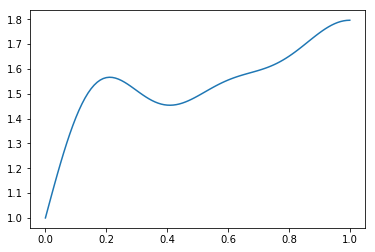

In [96]:
# Setup computational grid
h = .01 #mesh spacing
k=5 # terms in the K-L expansion of alpha
xval = np.arange(h, 1.0, h)
num_pts = len(xval)

xbp= np.arange(0,1.0+h,h)
coeff=np.random.rand(k)
alpha=alpha_func(xbp,coeff)
beta=5.0 #set it equal to mean value
#beta=10.0*np.random.rand(1) #beta is U[0,10].
#print(alpha)
#plt.plot(xbp,alpha)
#print(xbp.size)
#print(xval.size)

We model $\alpha(x)$ as a continuous random variable equal to $1+\xi$, where $\xi$ corresponds to a stochastic process with covariance equal to $\min(x_1,x_2)$ and weights drawn from $\mathcal{U}[0,1]$.

We plot a realization of $\alpha(x)$ with 20 K-L terms below:
Note that this expansion would give us a 20+1 dimensional input parameter space(the 20 $\alpha$ terms + the parameterization of the forcing term).


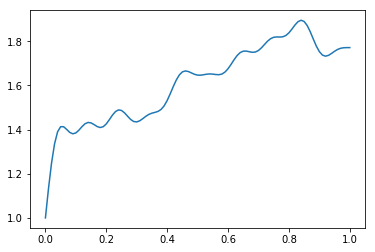

In [105]:
def plot_realize(xv,k=10):
    out=np.zeros(xv.shape)
    rv=np.random.rand(k)
    for i in range(1,k+1):
        out+=rv[i-1]*np.sqrt(eval(i))*efunc(xv,i)
    plt.plot(xv,1+out)
    plt.show()
    
plot_realize(xbp,k=20)

In [97]:
# Discretize BVP 

# Step 1: Define data b
# Uniform grid so can move h to right hand side
b = h**2*np.exp(beta*xval)

# define our beta vector.  We will take the first 5 terms of the KL 
# expansion of a wiener covarianece  
A = np.zeros((len(xval),len(xval)))
# Step 2: Define matrix A
# We use the spdiags command to map -1 2 -1 to the tridiagonal matrix A
#temp = np.hstack((-np.ones((num_pts,1)), 2.0*np.ones((num_pts,1)), -np.ones((num_pts,1)))).transpose()
#A = sparse.spdiags(temp, [-1,0,1], num_pts, num_pts, format = "csr")

def build_Amat(alpha): #alpha vector of grid point diffusion values
    n=alpha.size-2
    A = np.zeros((n,n))
    for i in range(n):
        A[i,i] = ( alpha[i] + alpha[i+2] )/2 + alpha[i+1]
        if i<n-1:
            A[i,i+1] = -( alpha[i+1] + alpha[i+2] ) / 2
        if i>0:
            A[i,i-1] = -( alpha[i] + alpha[i+1] ) / 2
    return A

# build stiffness matrix
A=build_Amat(alpha)
print(A) #debug

[[ 2.0911709  -1.06833538  0.         ...,  0.          0.          0.        ]
 [-1.06833538  2.1816594  -1.11332402 ...,  0.          0.          0.        ]
 [ 0.         -1.11332402  2.2707925  ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  3.58117024 -1.79227714  0.        ]
 [ 0.          0.          0.         ..., -1.79227714  3.58683787
  -1.79456073]
 [ 0.          0.          0.         ...,  0.         -1.79456073
   3.59027158]]


## What's the analytic solution?

We integrate once to get 
$$
\alpha(x) u_x = (\beta)^{-1} e^{\beta x} + C \quad \beta \neq 0
$$
and hence 
$$
u(x) = \beta^{-1} \int \frac{e^{\beta x}}{\alpha(x)} \; dx +C{\alpha}^{-1}x
$$
For $\alpha=1$ we can further simplify this expression to (assuming zero boundary conditions)
$$
u(x) = \beta^{-2} e^{\beta x} + c_1 x + c_2 \rightarrow c_2 = -\beta^{-2}; \quad c_1 = \beta^{-2} \left(1 - e^{\beta}\right)
$$

For $Q(u)=u_x(0)$ we then have 
$$
Q(\beta) = \beta^{-2} \left( 1 - e^\beta \right) + \beta^{-1}
$$
And for $Q(u)=u_x(1)$ we have:
$$
Q(\beta) = \beta^{-1} e^\beta +  -\beta^{-2} + \beta^{-2} \left(1 - e^{\beta}\right)
$$

[ 0.05040608  0.09856699  0.14468249  0.18893881  0.23150891  0.27255287
  0.31221855  0.35064229  0.3879497   0.42425639  0.45966866  0.49428427
  0.52819296  0.56147709  0.59421206  0.62646675  0.6583039   0.6897803
  0.7209471   0.75184987  0.78252876  0.81301852  0.8433485   0.87354264
  0.90361941  0.93359176  0.96346709  0.9932472   1.02292828  1.052501
  1.08195061  1.11125711  1.14039556  1.16933637  1.19804579  1.22648641
  1.25461771  1.28239669  1.30977855  1.33671729  1.36316636  1.38907921
  1.41440983  1.4391131   1.46314514  1.4864635   1.50902721  1.53079675
  1.55173395  1.57180169  1.59096367  1.60918398  1.62642668  1.6426554
  1.65783281  1.67192018  1.68487694  1.69666018  1.7072243   1.71652061
  1.72449702  1.73109776  1.73626315  1.73992948  1.74202886  1.74248927
  1.74123449  1.73818424  1.73325432  1.72635675  1.71739997  1.70628908
  1.69292603  1.67720982  1.65903665  1.63829999  1.6148906   1.58869644
  1.55960241  1.52749006  1.49223708  1.45371666  1.411

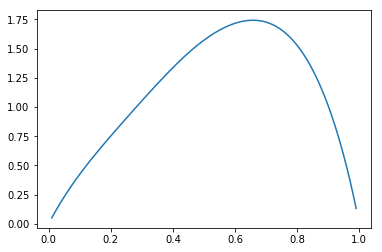

In [98]:
# Compute the approximate solution with CG method
U_h = np.linalg.solve(A, b)
print(U_h)
plt.plot(xval,U_h)

## Define the QoI

If our quantity of interest is the flux at the left boundary($x=0$), then this corresponds to $\alpha(x=1)u_x(x=1)$.  One discrete approximation would involve a forward difference of $u$, namely

$$
Q(u) \approx \alpha(x_n=1) \frac{u_{x_1} - u_{x_0}}{(x_1-x_0)=h}
$$
where 
$$
\alpha_x = 2+ \sum_{i=1}^{i=5} a_i \lambda_i \phi_i(x)
$$
(the first 5 terms of the K-L expansion).
As $u_{x_0}=0$ the flux expresion simplifies a little.

There are more accurate boundary flux approximations(assuming a smooth enough solution) but we will not pursue this in this example.

For our finite differenced QoI the boundary flux simply becomes a point evaluation functional, namely $(h)^{-1}\alpha(x_{n}) u(x_{n-1})$.
The corresponding Riesz representor $\psi$ is equal to $(h)^{-1}\alpha(x_{n-1}) e_{n-1}$.

Our $K-L$ expansion has $k=5$ parameters (the $a_i$).  The sensitivity of Q to a parameter $a_i$ is therefore equal to

$$
\frac{\partial Q}{\partial a_i}(u) + Q\left( \frac{\partial u}{\partial a_i} \right)
$$
which is equal to
$$
h^{-1} \lambda_i \phi_i(x=1) u(x_{n-1}) + < \frac{\partial A}{\partial a_i}, \Phi >
$$
where $\Phi$ solves the usual discrete adjoint problem
$$
A \phi = \psi = h^{-1} \alpha(x_{n-1}) e_{n-1}
$$



In [99]:
def flux_QoI(u,coeff,h):
    return 1/h*alpha_func(1.0,coeff)*u[-1]
    
def dQda(u,h,coeff):
    Qgrada=np.zeros(coeff.shape)
    for loop in range(Qgrada.size):
        Qgrada[loop]=1/h*eval(loop+1)*efunc(1.0,loop+1)*u[-1]
    print(Qgrada)
    return Qgrada

99


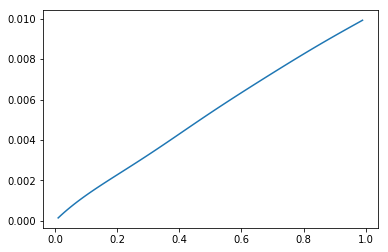

In [100]:
psi = np.zeros(xval.size)
print(xval.size)
psi[-1] = (xval[1]-xval[0])*alpha_func(np.array([1.0]),coeff)
phi= np.linalg.solve(A, psi)
plt.plot(xval,phi)
#print(A)
#print(alpha)

Notice that $dA/da_i$ collapses down to a matrix where the $\alpha(x)$ vector is replace with the $i$th term in the KL expansion, namely
$\sqrt{\lambda_i}{\phi_i(x)}$.

In [101]:
def dRda(xval,u,index):
    temp=eval(index+1)*efunc(xbp,index+1) # lambda_i phi_i(x)
    Amat=build_Amat(temp)
    return np.dot(Amat,u)

def Qduda(u,index,xval,phi):
    temp=dRda(xval,u,index)
    return np.dot(temp,phi)

    

In [102]:
Qgrada=np.zeros(5)
for i in range(5):
    Qgrada[i]=Qduda(U_h,i,xval,phi)
Qgrada*=h**(-2)  #This scaling is because he scaled \psi by h^2.
Qgrada+=dQda(U_h,h,coeff)
print(Qgrada)

[ 7.5282327  -0.8364703   0.30112931 -0.1536374   0.09294114]
[ 14.5805537   -1.51654674   0.59494821  -0.29780281   0.18591692]


For this particular problem the QoI is sensitive to the first few modes in the K-L expansion.  

## How do we use the gradient information?

* Active Subspaces(Jordan will talk about this on Monday)
* Adaptive surrogate construction(adapt in dimensions will large gradients, ignore others)
* Optimization 


## Things to Try:

1) Generate the first 20 coefficients for a K-L expansion.  Does the QoI change much if you use the first 5,10,15, or all coefficients?  

2) Fix the number of terms in the K-L expansion but check to see if your QoI changes with grid resolution.

3) Do a forward propagation over a 6D input space(5 KL-terms + 1 RHS term) assuming all parameters are $\mathcal{U}[0,1]$.  What does the 
pdf(via KDE) of the push-forward of the prior look like?
